In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [4]:
SPY_2DAY = pd.read_csv('E-mini S&P 500 minute data (2 days).csv')

In [5]:
def load_data():
    df = pd.read_csv(
        'E-mini S&P 500 minute data (2 days).csv', header=1)
    cols = ["Date Time", "Close"]
    data = df[cols]
    data = data.set_axis(["timestamp", "close"], axis=1)
    return data


def deltas():
    df = load_data()
    df["log"] = np.log(df["close"].astype(float))
    df["deltas"] = df["log"].diff()
    df.dropna(inplace=True)
    final_data = df[["timestamp", "close", "deltas"]]
    #final_data = final_data.set_axis(["timestamp", "close", "deltas"], axis=1)
    return final_data

In [30]:
data = deltas()

In [31]:
data[(data['timestamp'] >= '2022-02-09') & (data['timestamp'] < '2022-02-10')]

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
941,2022-02-09 23:55:00,4568.75,0.000219
942,2022-02-09 23:56:00,4569.25,0.000109
943,2022-02-09 23:57:00,4569.75,0.000109
944,2022-02-09 23:58:00,4571.75,0.000438


In [32]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [33]:
df_testing = pd.DataFrame(np.log(data.close).diff().diff(12))
adf_check(df_testing.close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -16.640431015771668
p-value : 1.6364587817462715e-29
Number of Lags Used : 23
Number of Observations Used : 1882
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [34]:
data

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
1915,2022-02-10 17:09:00,4491.00,-0.000612
1916,2022-02-10 17:10:00,4493.00,0.000445
1917,2022-02-10 17:11:00,4493.25,0.000056
1918,2022-02-10 17:12:00,4494.25,0.000223


In [35]:

def AR(p, df):
#Generating the lagged p terms
    df_temp = df

    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['close'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_val = pd.DataFrame(df_temp[train_size:df_temp.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    try:
        X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    except:
        return [pd.DataFrame(), pd.DataFrame(), 0, 0, float("inf")]
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,1].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_val = df_val.iloc[:,1:].values.reshape(-1,p)
    df_val['Predicted_Values'] = X_val.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_val['close'], df_val['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_val,theta,intercept,RMSE]

In [36]:
def opt_p (df_testing, low_p, up_p):
    best_p = 0
    best_rmse = float("inf")
    for p in range(low_p, up_p):
        df_train_2,df_val,theta,intercept,RMSE = AR(p, pd.DataFrame(df_testing))
        if RMSE<best_rmse:
            best_p = p
            best_rmse = RMSE
    return best_p, best_rmse


In [37]:
copy = df_testing.copy(deep = True)
best_p, best_rmse = opt_p(copy, 1, 21)
df_train_2,df_val,theta,intercept,RMSE = AR(best_p, df_testing)
df_c = pd.concat([df_train_2,df_val])
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

<ipython-input-35-40ab4a1db949>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-35-40ab4a1db949>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-35-40ab4a1db949>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

The RMSE is : 0.0011368740889626352 , Value of p :  1
The RMSE is : 0.0011368740889626356 , Value of p :  2
The RMSE is : 0.0011368740889626352 , Value of p :  3
The RMSE is : 0.001136874088962635 , Value of p :  4
The RMSE is : 0.0011368740889626352 , Value of p :  5
The RMSE is : 0.0011368740889626352 , Value of p :  6
The RMSE is : 0.0011368740889626352 , Value of p :  7
The RMSE is : 0.0011368740889626358 , Value of p :  8
The RMSE is : 0.001136874088962635 , Value of p :  9
The RMSE is : 0.0011368740889626345 , Value of p :  10
The RMSE is : 0.001136874088962635 , Value of p :  11
The RMSE is : 0.0011368740889626354 , Value of p :  12
The RMSE is : 0.0011368740889626356 , Value of p :  13
The RMSE is : 0.001136874088962635 , Value of p :  14
The RMSE is : 0.0011368740889626356 , Value of p :  15
The RMSE is : 0.0011368740889626354 , Value of p :  16
The RMSE is : 0.001136874088962635 , Value of p :  17
The RMSE is : 0.0011368740889626352 , Value of p :  18
The RMSE is : 0.00113687

<ipython-input-35-40ab4a1db949>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


In [38]:
res

,Residuals
24,-0.000165
25,-0.000110
26,0.000329
27,0.000055
28,0.000274
...,...
1915,-0.000278
1916,0.000724
1917,-0.000278
1918,0.000723


In [39]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_val = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()

    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_val = res_val.iloc[:,1:].values.reshape(-1,q)
    res_val['Predicted_Values'] = X_val.dot(lr.coef_.T) + lr.intercept_
    res_val[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_val['Residuals'], res_val['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_val,theta,intercept,RMSE]

In [40]:
def opt_q (res, low_q, up_q):
    best_q = 0
    best_rmse = float("inf")
    for q in range(low_q, up_q):
        res_train_2,res_val,theta,intercept,RMSE = MA(q, pd.DataFrame(res))
        if RMSE<best_rmse:
            best_q = q
            best_rmse = RMSE
    return best_q, best_rmse

<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

The RMSE is : 0.0010111307055400934 , Value of q :  1
The RMSE is : 0.0008980664466804939 , Value of q :  2
The RMSE is : 0.0008632433167319869 , Value of q :  3
The RMSE is : 0.0008690947922185553 , Value of q :  4
The RMSE is : 0.000864347181877588 , Value of q :  5
The RMSE is : 0.0008585875677181586 , Value of q :  6


<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

The RMSE is : 0.0008637085950386737 , Value of q :  7
The RMSE is : 0.0008617442979740181 , Value of q :  8
The RMSE is : 0.0008435590168626025 , Value of q :  9
The RMSE is : 0.0008400132150945481 , Value of q :  10
The RMSE is : 0.0007803219910310734 , Value of q :  11
The RMSE is : 0.000756062121606234 , Value of q :  12


<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

The RMSE is : 0.0007457506699452667 , Value of q :  13
The RMSE is : 0.0007384839412942892 , Value of q :  14
The RMSE is : 0.0007339086085884495 , Value of q :  15
The RMSE is : 0.0007375102846899795 , Value of q :  16
The RMSE is : 0.0007353466313536154 , Value of q :  17
The RMSE is : 0.0007329312181226664 , Value of q :  18


<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-39-11e2fcf2375b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

The RMSE is : 0.0007315078065800935 , Value of q :  19
The RMSE is : 0.0007334037310334831 , Value of q :  20
The RMSE is : 0.0007315078065800935 , Value of q :  19


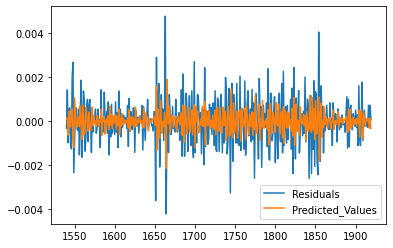

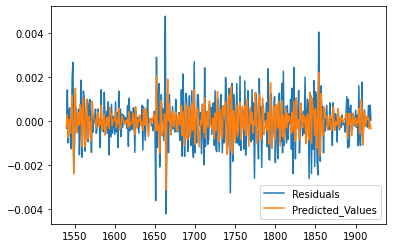

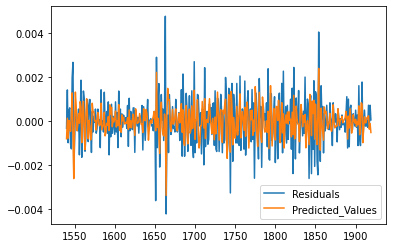

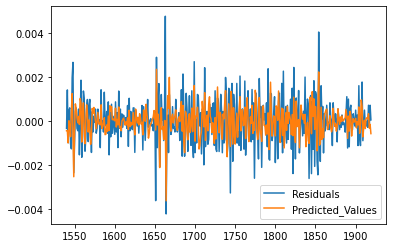

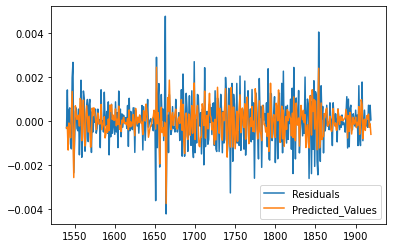

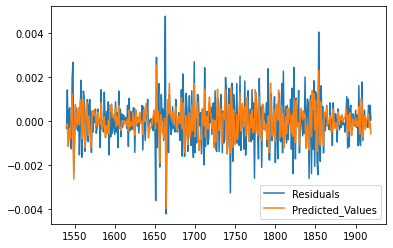

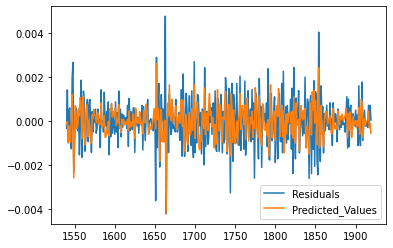

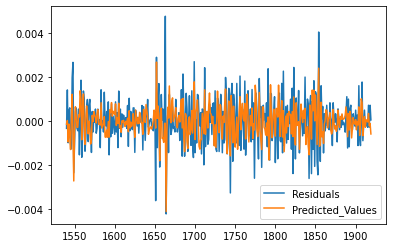

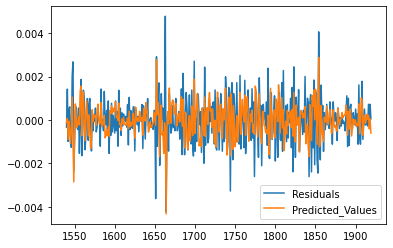

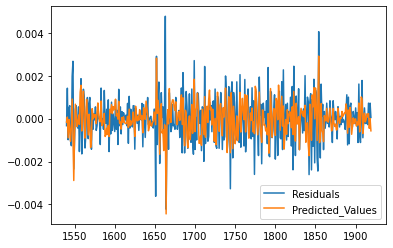

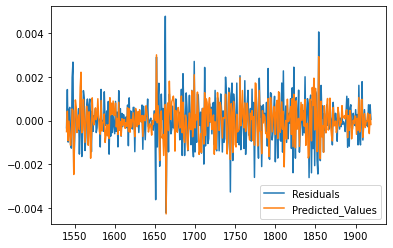

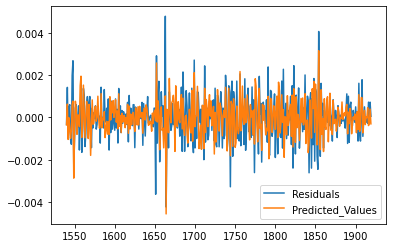

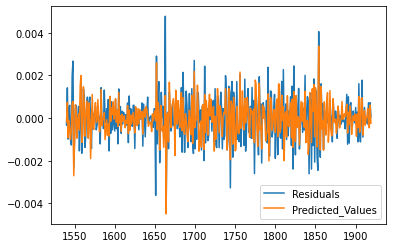

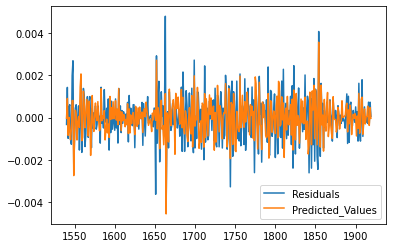

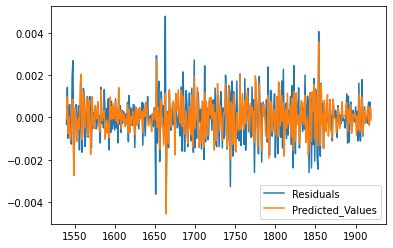

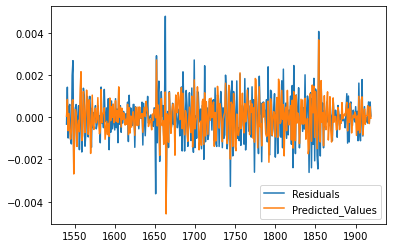

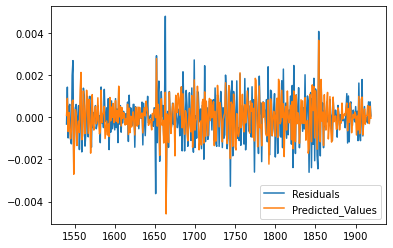

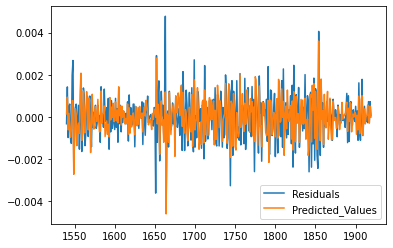

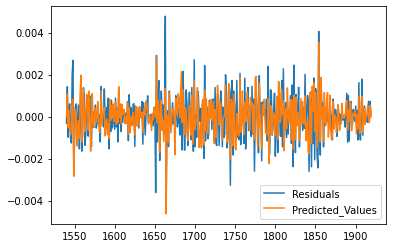

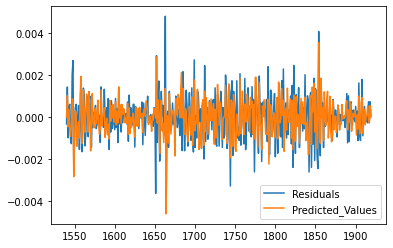

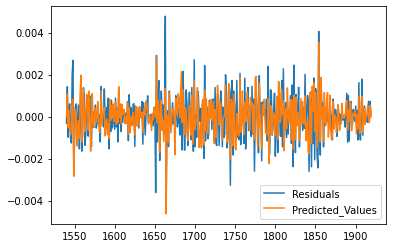

In [41]:

copy = res.copy(deep = True)
best_q, best_rmse = opt_q(copy, 1, 21)
res_train_2,res_val,theta,intercept,RMSE = MA(best_q, res)

(-0.003, 0.002)

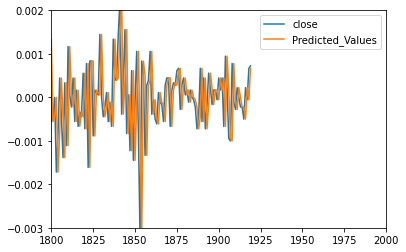

In [66]:
df_c = pd.concat([df_train_2,df_val])

import matplotlib.pyplot as plt
df_c[['close','Predicted_Values']].plot()
plt.xlim(1800, 2000)
plt.ylim(-.003, .002)

# df_c

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [44]:
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

In [45]:
res_c = pd.concat([res_train_2,res_val])


In [46]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,...,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Shifted_values_17,Shifted_values_18,Shifted_values_19,Predicted_Values
43,-2.744282e-04,-2.195329e-04,4.390960e-04,-2.744312e-04,1.098147e-04,-4.392196e-04,0.000220,0.000055,-0.000220,0.000384,...,-0.000439,0.000055,0.000220,-0.000549,0.000274,0.000055,3.294591e-04,-1.098629e-04,-1.646587e-04,0.000008
44,4.390267e-04,-2.744282e-04,-2.195329e-04,4.390960e-04,-2.744312e-04,1.098147e-04,-0.000439,0.000220,0.000055,-0.000220,...,0.000110,-0.000439,0.000055,0.000220,-0.000549,0.000274,5.482900e-05,3.294591e-04,-1.098629e-04,0.000513
45,1.098388e-04,4.390267e-04,-2.744282e-04,-2.195329e-04,4.390960e-04,-2.744312e-04,0.000110,-0.000439,0.000220,0.000055,...,0.000384,0.000110,-0.000439,0.000055,0.000220,-0.000549,2.744523e-04,5.482900e-05,3.294591e-04,0.000024
46,1.506300e-08,1.098388e-04,4.390267e-04,-2.744282e-04,-2.195329e-04,4.390960e-04,-0.000274,0.000110,-0.000439,0.000220,...,-0.000220,0.000384,0.000110,-0.000439,0.000055,0.000220,-5.488896e-04,2.744523e-04,5.482900e-05,-0.000282
47,-5.491337e-05,1.506300e-08,1.098388e-04,4.390267e-04,-2.744282e-04,-2.195329e-04,0.000439,-0.000274,0.000110,-0.000439,...,0.000055,-0.000220,0.000384,0.000110,-0.000439,0.000055,2.195510e-04,-5.488896e-04,2.744523e-04,-0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-1.668566e-04,-0.000891,0.001781,-0.000056,-0.001113,...,0.001615,-0.001114,0.000279,-0.000278,0.000501,-0.000223,-1.549332e-08,3.340168e-04,-3.897070e-04,0.000524
1916,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-0.000167,-0.000891,0.001781,-0.000056,...,-0.000780,0.001615,-0.001114,0.000279,-0.000278,0.000501,-2.226149e-04,-1.549332e-08,3.340168e-04,-0.000132
1917,-2.783174e-04,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,0.000501,-0.000167,-0.000891,0.001781,...,-0.001113,-0.000780,0.001615,-0.001114,0.000279,-0.000278,5.008455e-04,-2.226149e-04,-1.549332e-08,-0.000279
1918,7.231695e-04,-2.783174e-04,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-0.000223,0.000501,-0.000167,-0.000891,...,-0.000056,-0.001113,-0.000780,0.001615,-0.001114,0.000279,-2.783112e-04,5.008455e-04,-2.226149e-04,0.000528


In [47]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:>

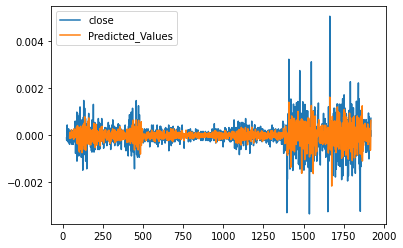

In [48]:
df_c[['close','Predicted_Values']].plot()

In [49]:
df_c.close += np.log(data.close).shift(1)
df_c.close += np.log(data.close).diff().shift(12)
df_c.Predicted_Values += np.log(data.close ).shift(1)
df_c.Predicted_Values += np.log(data.close).diff().shift(12)
df_c.close = np.exp(df_c.close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [50]:
df_c

,close,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Predicted_Values
24,4554.25,0.000055,-0.000055,1.646316e-04,1.646497e-04,-1.097394e-04,-2.195239e-04,1.646497e-04,-0.000055,-0.000165,0.000165,NaN
25,4553.00,-0.000110,0.000055,-5.492240e-05,1.646316e-04,1.646497e-04,-1.097394e-04,-2.195239e-04,0.000165,-0.000055,-0.000165,NaN
26,4553.75,-0.000220,-0.000110,5.489529e-05,-5.492240e-05,1.646316e-04,1.646497e-04,-1.097394e-04,-0.000220,0.000165,-0.000055,NaN
27,4554.00,0.000110,-0.000220,-1.097635e-04,5.489529e-05,-5.492240e-05,1.646316e-04,1.646497e-04,-0.000110,-0.000220,0.000165,NaN
28,4555.25,0.000165,0.000110,-2.196264e-04,-1.097635e-04,5.489529e-05,-5.492240e-05,1.646316e-04,0.000165,-0.000110,-0.000220,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1915,4491.00,-0.000223,-0.000223,-1.950725e-07,2.226552e-04,-2.782524e-04,-1.113957e-04,7.792869e-04,-0.001002,-0.000946,0.000167,4494.605471
1916,4493.00,-0.000501,-0.000223,-2.225344e-04,-1.950725e-07,2.226552e-04,-2.782524e-04,-1.113957e-04,0.000779,-0.001002,-0.000946,4489.157168
1917,4493.25,0.000223,-0.000501,-2.225158e-04,-2.225344e-04,-1.950725e-07,2.226552e-04,-2.782524e-04,-0.000111,0.000779,-0.001002,4493.248554
1918,4494.25,-0.000056,0.000223,-5.008827e-04,-2.225158e-04,-2.225344e-04,-1.950725e-07,2.226552e-04,-0.000278,-0.000111,0.000779,4493.373726


close                 0
Shifted_values_1      0
Shifted_values_2      0
Shifted_values_3      0
Shifted_values_4      0
Shifted_values_5      0
Shifted_values_6      0
Shifted_values_7      0
Shifted_values_8      0
Shifted_values_9      0
Shifted_values_10     0
Predicted_Values     19
dtype: int64

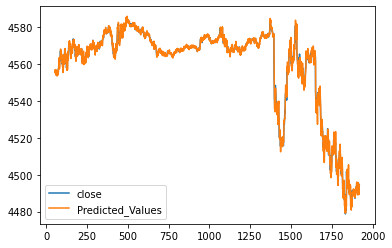

In [51]:
df_c.iloc[30:,:][['close','Predicted_Values']].plot()
np.sum(df_c.isna())